This script processes a set of raster files representing land-use categories and tree cover data. The main goal is to features and deforestation raster files based on the given land-use category raster files. The script performs the following steps:

1. Import necessary libraries and set up the required paths and constants.
2. Define a crop_and_mask_raster function that takes the paths of the source raster, property raster, output raster, and the maximum height and width. This function reads the source and property rasters, pads them to the same dimensions, creates a mask using the property raster, and applies the mask to the source raster. Finally, the masked raster is saved with updated metadata.

5. Determine the maximum dimensions and deforestation files up to the matching year of the mask.
6. Process the files by calling the crop_and_mask_raster function with the appropriate parameters.


The output is a set of masked raster files for each feature and the target variable which are cropped and masked based on the land use plans.



# Import Libraries

In [1]:
import os
import sys
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling



# Import Constants

In [2]:
# Get the current working directory
current_dir = os.path.abspath('')

# Search for the 'constants.py' file starting from the current directory and moving up the hierarchy
project_root = current_dir
while not os.path.isfile(os.path.join(project_root, 'constants.py')):
    project_root = os.path.dirname(project_root)

# Add the project root to the Python path
sys.path.append(project_root)


In [3]:
from constants import (SERVER_PATH,
 OUTPUT_PATH,
  LUP_LUT_RASTER,
   DEFORESTATION_1120_PATH,
    TREECOVER_2010, SOIL_RASTER, 
    ROAD_DISTANCE_RASTER,
     RIVER_DISTANCE_RASTER,
     PRECIPITATION_FILEPATH)


In [4]:
PRECIPITATION_FILEPATH


'/Users/romero61/../../capstone/pyforest/ml_data/raw_CHIRPS/average_annual_precipitation.tif'

In [5]:
# Constants
# update the first rasters_to_use_as_mask with the folder with the raster you want to use as a mask
raster_to_use_as_mask = LUP_LUT_RASTER

# new output directory
output_folder = os.path.join(SERVER_PATH, 'ml_data', 'output', 'masked_rasters')


In [6]:
def crop_and_mask_raster(src_raster_path, property_raster_path, output_raster_path, max_height, max_width):
    with rasterio.open(src_raster_path) as src:
        # Read the source raster
        src_data = src.read(1)
        
        with rasterio.open(property_raster_path) as property_raster:
            # Read the property limits raster
            property_data = property_raster.read(1)

            # Pad both the source data and property data to the maximum dimensions
            src_data = np.pad(src_data, ((0, max_height - src_data.shape[0]), (0, max_width - src_data.shape[1])), constant_values=0)
            property_data = np.pad(property_data, ((0, max_height - property_data.shape[0]), (0, max_width - property_data.shape[1])), constant_values=0)

            # Create a mask using the padded property limits raster, where zero values are considered as nodata
            mask_data = (property_data != 0)

            # Check if the nodata value is set for the source raster, otherwise use a default value
            nodata_value = src.nodata if src.nodata is not None else -1

            # Apply the mask to the source raster
            src_data_masked = np.where(mask_data, src_data, nodata_value)
            print(f"Source data shape:{src_data.shape} Property data shape:{property_data.shape} Mask data shape:, {mask_data.shape} After masking: Source data masked shape:, {src_data_masked.shape}")

             # Save the masked raster
            profile = src.profile
            profile['height'] = max_height
            profile['width'] = max_width
            profile['nodata'] = nodata_value
            profile['dtype'] = 'int16'
            with rasterio.open(output_raster_path, 'w', **profile) as dst:
                dst.write(src_data_masked.astype(profile['dtype']), 1)



In [7]:
# Dimensions
max_height, max_width = 0, 0
with rasterio.open(TREECOVER_2010) as tree_cover_src:
     with rasterio.open(DEFORESTATION_1120_PATH) as deforestation_src, rasterio.open(LUP_LUT_RASTER) as mask_src:
        # Determine the maximum dimensions of all rasters
        max_height = max(max_height, mask_src.height, tree_cover_src.height, deforestation_src.height)
        max_width = max(max_width, mask_src.width, tree_cover_src.width, deforestation_src.width)
        print(max_height)
        print(max_width)




22512
20381


# Process Files

## Intital Stack

In [9]:
# Process TREECOVER_2010
tree_cover_output_raster = os.path.join(output_folder, 'treecover_2010_masked.tif')
crop_and_mask_raster(TREECOVER_2010, raster_to_use_as_mask, tree_cover_output_raster, max_height, max_width)

# Process DEFORESTATION_1120_PATH
deforestation_1120_output_raster = os.path.join(output_folder, 'deforestation11_20_masked.tif')
crop_and_mask_raster(DEFORESTATION_1120_PATH, raster_to_use_as_mask, deforestation_1120_output_raster, max_height, max_width)   

# Process LUP_LUT_RASTER
lup_masked_output_raster = os.path.join(output_folder,'lup_10_masked.tif')
crop_and_mask_raster(LUP_LUT_RASTER, raster_to_use_as_mask, lup_masked_output_raster, max_height, max_width)


22512
20381
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


## Soil

<Axes: >

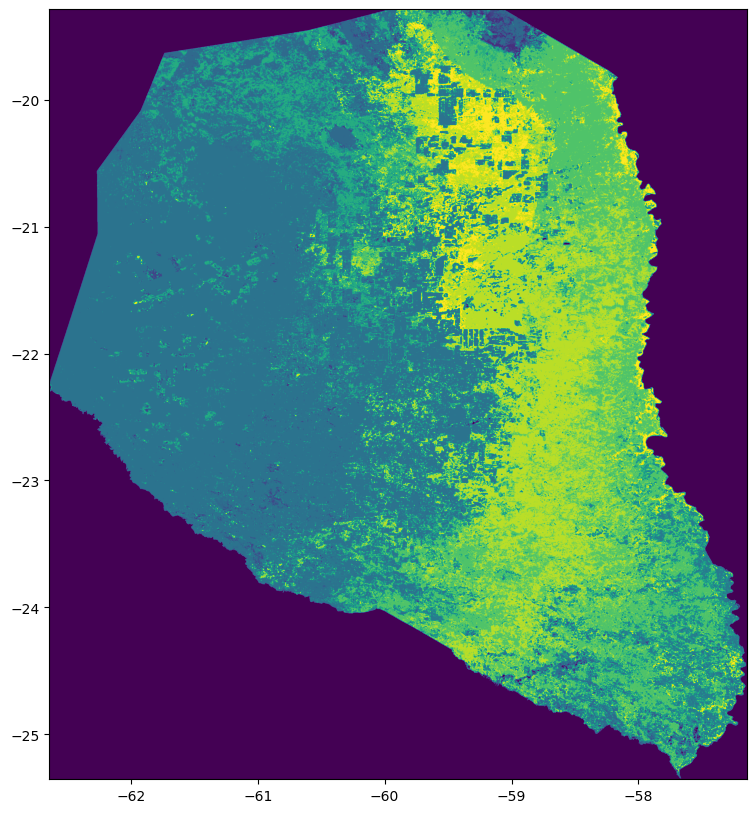

In [14]:
from rasterio.plot import show

# Open example raster
raster = rasterio.open(SOIL_RASTER)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(raster, ax = ax)
plt.gca()

In [17]:

# Open the reference raster
with rasterio.open(TREECOVER_2010) as ref_raster:
    ref_transform = ref_raster.transform
    ref_crs = ref_raster.crs
    ref_width = ref_raster.width
    ref_height = ref_raster.height

    # Open the raster to be resampled
    with rasterio.open(SOIL_RASTER) as soil_raster:
        soil_data = soil_raster.read(1)

        # Create a new array for the resampled data
        resampled_data = np.empty(shape=(ref_height, ref_width))

        # Resample the soil data
        reproject(
            source=soil_data,
            destination=resampled_data,
            src_transform=soil_raster.transform,
            src_crs=soil_raster.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.nearest)

        # Write the resampled data to a new raster file
        with rasterio.open('resampled_soil.tif', 'w', driver='GTiff',
                           height=ref_height, width=ref_width,
                           count=1, dtype=str(soil_data.dtype),
                           crs=ref_crs, transform=ref_transform) as dst:
            dst.write(resampled_data, 1)

soil_masked_output_raster = os.path.join(output_folder,'soil_masked.tif')
#pass the resampled soil data to your crop_and_mask_raster function
crop_and_mask_raster('resampled_soil.tif', raster_to_use_as_mask, soil_masked_output_raster, max_height, max_width)

Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


## Distance Rasters, Treecover2000(%), DF01_10

In [8]:
# Process ROAD_RASTER
road_masked_output_raster = os.path.join(output_folder,'road_masked.tif')
crop_and_mask_raster(ROAD_DISTANCE_RASTER, raster_to_use_as_mask, road_masked_output_raster, max_height, max_width)

Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


In [8]:
# Process RIVER_RASTER
river_masked_output_raster = os.path.join(output_folder,'river_masked.tif')
crop_and_mask_raster(RIVER_DISTANCE_RASTER, raster_to_use_as_mask, river_masked_output_raster, max_height, max_width)


Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


In [8]:
# Process PRECIPITATION_FILEPATH
precipitation_masked_output_raster = os.path.join(output_folder,'precipitation_masked.tif')
crop_and_mask_raster(PRECIPITATION_FILEPATH, raster_to_use_as_mask, precipitation_masked_output_raster, max_height, max_width)


Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
